Loading data from: ../data/hdf5_data_final\t15.2023.08.11\data_train.hdf5


AttributeError: 'str' object has no attribute 'decode'

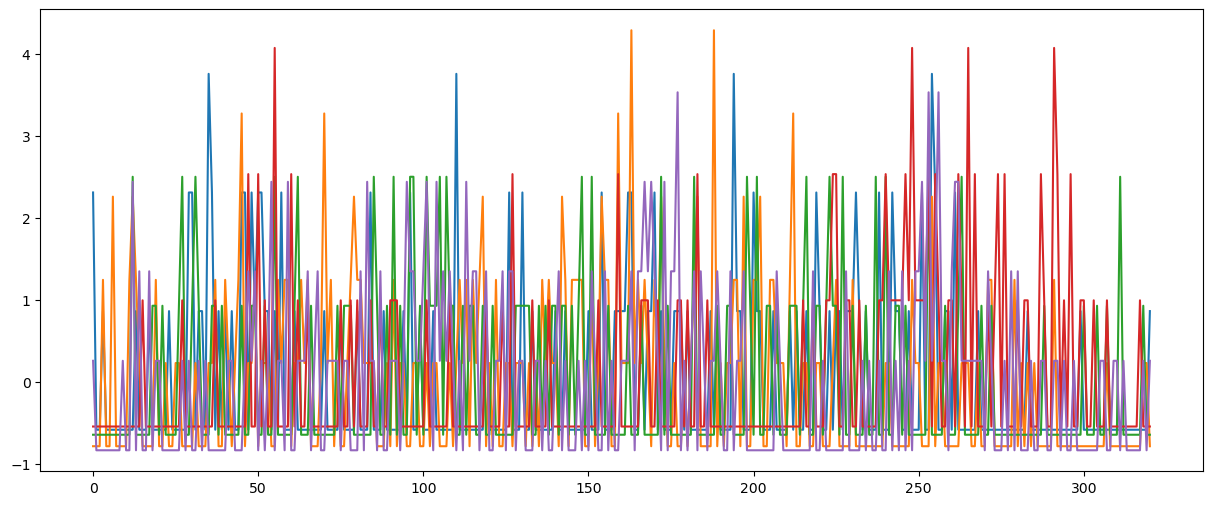

In [8]:
import h5py
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

# Copying load_h5py_file and its dependencies from model_training/evaluate_model_helpers.py
# and data_augmentations.py for self-contained notebook.

def _extract_transcription(input):
    endIdx = np.argwhere(input == 0)[0, 0]
    trans = ''
    for c in range(endIdx):
        trans += chr(input[c])
    return trans

def load_h5py_file(file_path, b2txt_csv_df):
    data = {
        'neural_features': [],
        'n_time_steps': [],
        'seq_class_ids': [],
        'seq_len': [],
        'transcriptions': [],
        'sentence_label': [],
        'session': [],
        'block_num': [],
        'trial_num': [],
        'corpus': [],
    }
    # Open the hdf5 file for that day
    with h5py.File(file_path, 'r') as f:

        keys = list(f.keys())

        # For each trial in the selected trials in that day
        for key in keys:
            g = f[key]

            neural_features = g['input_features'][:]
            n_time_steps = g.attrs['n_time_steps']
            seq_class_ids = g['seq_class_ids'][:] if 'seq_class_ids' in g else None
            seq_len = g.attrs['seq_len'] if 'seq_len' in g.attrs else None
            transcription = g['transcription'][:] if 'transcription' in g else None
            sentence_label = g.attrs['sentence_label'][:] if 'sentence_label' in g.attrs else None
            session = g.attrs['session']
            block_num = g.attrs['block_num']
            trial_num = g.attrs['trial_num']

            # match this trial up with the csv to get the corpus name
            year, month, day = session.split('.')[1:]
            date = f'{year}-{month}-{day}'
            row = b2txt_csv_df[(b2txt_csv_df['Date'] == date) & (b2txt_csv_df['Block number'] == block_num)]
            corpus_name = row['Corpus'].values[0]

            data['neural_features'].append(neural_features)
            data['n_time_steps'].append(n_time_steps)
            data['seq_class_ids'].append(seq_class_ids)
            data['seq_len'].append(seq_len)
            data['transcriptions'].append(transcription)
            data['sentence_label'].append(sentence_label)
            data['session'].append(session)
            data['block_num'].append(block_num)
            data['trial_num'].append(trial_num)
            data['corpus'].append(corpus_name)
    return data

# Load the t15_copyTaskData_description.csv file
csv_path = '../data/t15_copyTaskData_description.csv'
b2txt_csv_df = pd.read_csv(csv_path)

# List a few .hdf5 files to load
hdf5_data_dir = '../data/hdf5_data_final'
first_session_dir = os.path.join(hdf5_data_dir, os.listdir(hdf5_data_dir)[0])
hdf5_file_path = os.path.join(first_session_dir, [f for f in os.listdir(first_session_dir) if f.endswith('.hdf5')][0])

print(f"Loading data from: {hdf5_file_path}")
loaded_data = load_h5py_file(hdf5_file_path, b2txt_csv_df)

# Visualize neuroactivity for the first trial
if loaded_data['neural_features']:
    first_trial_neural_features = loaded_data['neural_features'][0]
    sentence_label = loaded_data['sentence_label'][0]
    
    # Each trial has 512 neural features. Let's plot the first few for demonstration.
    plt.figure(figsize=(15, 6))
    for i in range(min(5, first_trial_neural_features.shape[1])): # Plot first 5 features
        plt.plot(first_trial_neural_features[:, i], label=f'Feature {i+1}')
    
    plt.title(f'Neural Activity for Trial (Sentence: {sentence_label.decode("utf-8")})')
    plt.xlabel('Time Steps')
    plt.ylabel('Feature Value')
    plt.legend()
    plt.grid(True)
    plt.show()

    print(f"Successfully loaded and visualized neural features from {hdf5_file_path}")
else:
    print(f"No neural features found in {hdf5_file_path}")


